In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

## Solving Laplace Equation
<h2><center> $\nabla^2 u(x,y) = 0$,</center></h2>

### for boundary condition
<h3><center> $u(0, y) = \sin(\pi y),\quad u(1, y) = 0,$</center></h3>
<h3><center> $u(x, 0) = 0,\quad u(x, 1) = 0.$</center></h3>

### Analytic solution:
<h3><center> $u(x,y) = \sum_{n=0}^{\infty} A_n \sinh[(n+1)\pi (x-1)] \sin[(n+1)\pi y]$</center></h3>

#### where
<h3><center> $A_n = -\frac{2}{ \sinh((n+1)\pi)} \int_0^1 \sin(\pi y)\sin((n+1)\pi y) dy =  -\frac{2 \sin(n \pi)}{n \pi(n+2)\sinh((n+1)\pi) } 
= \begin{cases} - \frac{1}{\sinh \pi } &, n=0 \\ 0 &, otherwise \end{cases}$</center></h3>

#### So,
<h3><center> $u(x,y) = - \frac{\sinh (\pi(x-1)) \sin(\pi y)}{\sinh \pi }.$</center></h3>


[link](https://en.wikiversity.org/wiki/Partial_differential_equations/Laplace_Equation)

#### Since we know the exact solution, given the boundary value, we can calculate RMSE of the estimated solution on each epoch.

In [3]:
def exact_solution(x,y,sin=np.sin, sinh=np.sinh):
    return -sinh(np.pi*(x-1))*sin(np.pi*y)/np.sinh(np.pi)

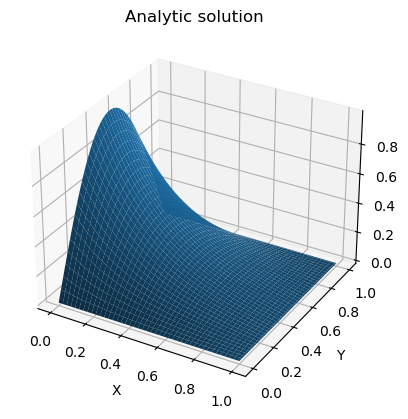

In [36]:
# Define the 2-dimensional domain
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X,Y = np.meshgrid(x, y, indexing='ij')
# Find the analytic solution over the deoman
sol = exact_solution(X, Y)

def plot_surf(X,Y, sol, scatter=False, ax= None):
    """Ploting helper function"""
    if ax is None:
        ax = fig.add_subplot(projection='3d')
    if scatter:
        ax.scatter(X,Y,sol, marker='.')
    else:
        ax.plot_surface(X,Y,sol)
    plt.xlabel("X"); plt.ylabel("Y")
fig = plt.figure()    
plot_surf(X,Y, sol)
plt.title("Analytic solution");     
plt.show()

# Using a neural net to estimate the solution 

In [5]:
# Define the2-dimensional domain in pytorch
x = torch.linspace(0, 1, 128).to(device)
y = torch.linspace(0, 1, 128).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
# define the boundary point in (x,y) coordinates
boundary_X_x = torch.hstack([x, 
                             x,
                             torch.ones_like(y)*x[0].item(), 
                             torch.ones_like(y)*x[-1].item()])
boundary_X_y = torch.hstack([torch.ones_like(x)*y[0].item(), 
                             torch.ones_like(x)*y[-1].item(),
                             y,
                             y])
boundary_X = torch.vstack([boundary_X_x, boundary_X_y]).T
def boundary_function(x):
    """Boundary values
       The function is everywhere zero, except at x=0
       which is sin(pi x)
    """
    return torch.where( x[:, 0] == 0, 
                       torch.sin(np.pi*x[:, 1]), 
                       0)
# define boundary values atbaoundary points
boundary_f = boundary_function(boundary_X).to(device)
# domain points as (x,y) columnar tensor in pytorch
# the Laplacian will be calculated by this tensor
physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
# The actual solution for calculating RMSE of the prediction
actual_f = exact_solution(X, Y, sin=torch.sin, sinh=torch.sinh).flatten()
# A dense neural net with 4 hidden layers, each with 128 nodes
model = Net_dense([2, 128, 128, 128, 128, 1]).to(device)
# The Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
# loss values and their corresponding regulation weights
loss_boundary = 0.0
lambda_boundary = 1.0
loss_physics = 0.0
lambda_physics = 1e-3
#
epochs = 50000
# Array for storing loss and RMSE
losses = np.zeros((2, epochs))
rmses = np.zeros( epochs)

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # boundary loss
    boundary_f_hat = model(boundary_X).squeeze()
    loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)
    #################################
    # physics derivatives
    physics_f = model(physics_X).squeeze()
    laplacian = Laplacian(physics_f, physics_X)
    ################################
    # physics loss
    loss_physics = torch.mean(laplacian**2)    
    ################################
    # Joint total loss
    total_loss = (
        +lambda_boundary*loss_boundary
        +lambda_physics*loss_physics
                    )
    # Back propagate step
    total_loss.backward(retain_graph=True)
    optimizer.step()
    # store the losses
    losses[:,i] = (loss_boundary.item(), loss_physics.item())
    # Calculate and store RMSE
    f = model(physics_X).squeeze()
    rmses[i] = torch.sqrt(torch.mean((actual_f-f)**2)).item()


## Plot loss values and RMSE

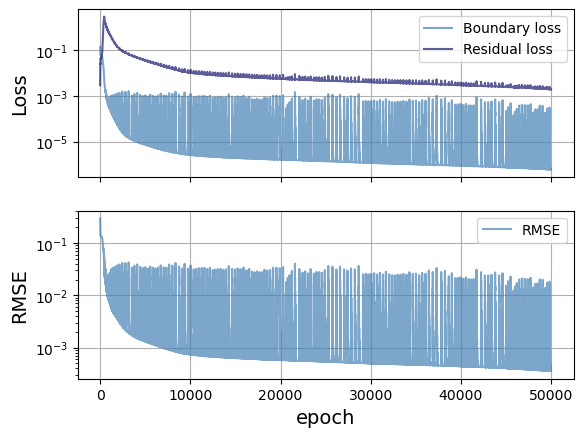

In [34]:
ax=plt.subplot(211)
ax.plot(losses[0,:], alpha=.7,color='steelblue', label="Boundary loss")
ax.plot(losses[1,:], alpha=.7,color='midnightblue', label="Residual loss")
ax.set_xticklabels([])
ax.grid(True)
plt.grid()
ax.set_ylabel("Loss", fontsize=14)
plt.yscale('log');plt.legend();plt.grid()
ax=plt.subplot(212)
ax.plot(rmses, '-', color='steelblue', alpha=.7, label="RMSE")
plt.yscale('log'); 
ax.set_xlabel("epoch", fontsize=14); ax.set_ylabel("RMSE", fontsize=14)
plt.legend();plt.grid()
plt.show()

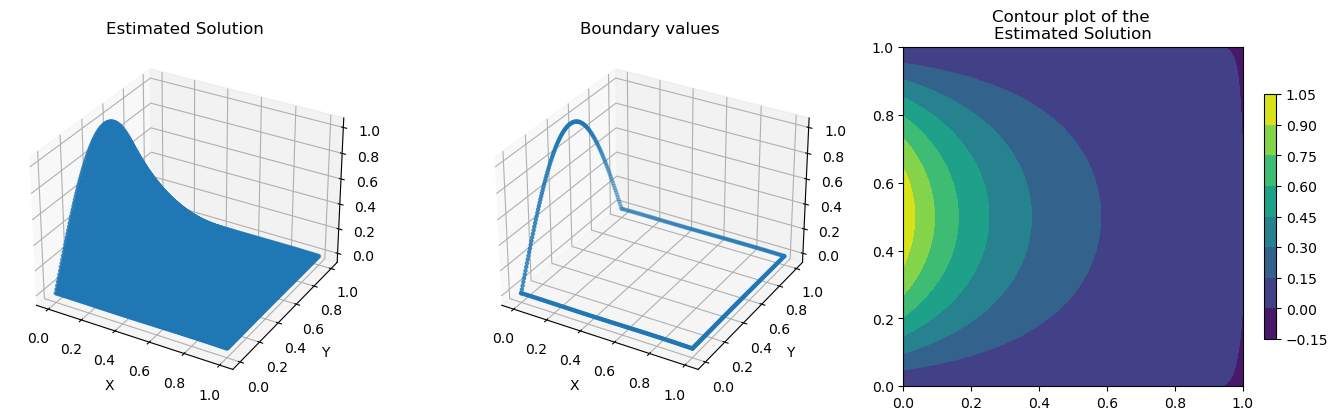

In [51]:
solution = model(physics_X).cpu().detach()

plt.figure(figsize=(14,4))
ax=plt.subplot(131,projection='3d')
plot_surf(physics_X[:,0].cpu().detach(), 
          physics_X[:,1].cpu().detach(),
          solution,
          scatter=True,
          ax=ax)
ax.set_title("Estimated Solution")
ax=plt.subplot(132, projection='3d')
boundary_solution = model(boundary_X).cpu().detach()
plot_surf(boundary_X[:,0].cpu().detach(), 
          boundary_X[:,1].cpu().detach(),
          boundary_solution,
          scatter=True,
          ax=ax)
ax.set_title("Boundary values")
ax=plt.subplot(133)
solution = model(physics_X).cpu().detach().reshape((x.shape[0], y.shape[0]))
plt.contourf(X.cpu().detach(), Y.cpu().detach(), solution)
plt.colorbar(shrink=.7);
ax.set_aspect(1.0)
ax.set_title("Contour plot of the \nEstimated Solution")
plt.tight_layout()